# Maximum Likelihood Estimation for Gaussian Random Variables

##### ID CIMA-ML : 324982348MLS
##### SD : Quyen Linh TA

This tutorial demonstrates how to find the maximum likelihood estimates of the mean $\mu$ and the variance $\sigma^2$ both analytically and using gradient descent for a Gaussian random variable $X$. The probability density function of $X$ is:

$$f_X(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left({-\frac{(x-\mu)^2}{2\sigma^2}}\right)$$

Suppose that you observe 500 independent and identically distributed (i.i.d) samples of $X$:

In [37]:
import torch
mu = 2
sigma = 3
num_samples = 500

X = torch.randn((num_samples,),requires_grad = False)
X = sigma*X + mu

print('Number of samples: {}\nVariance: {}\nMean: {}'.format(X.shape[0],*torch.var_mean(X)))

Number of samples: 500
Variance: 9.661876678466797
Mean: 1.8334250450134277


The independence assumption is valid if observing one of the samples does not give you information about the other samples, while the identical distribution assumption makes sense if these observations originated from the same underlying random experiment. Therefore, the dataset $\mathcal{D}$ is:

$$\mathcal{D} = \{X = x_1,X = x_2,...,X = x_{500}\}$$

The likelihood function is therefore:

$$ p(\mathcal{D};\mu,\sigma^2) = \prod_{i=1}^{500}f_X(x_i;\mu_i,\sigma_{i}^2) = \prod_{i=1}^{500} \frac{1}{\sqrt{2\pi\sigma_{i}^2}} \exp\left({-\frac{(x_i-\mu_i)^2}{2\sigma_{i}^2}}\right) $$

Since the samples are identically distributed:

$$
\mu_1 = \mu_2 = ... = \mu_{500} = \mu \\
\sigma_{1}^2 = \sigma_{2}^2 = ... = \sigma_{500}^2 = \sigma^2
$$

Then the log-likelihood function is:

\begin{align}
\ln(p(\mathcal{D};\mu,\sigma^2)) &= \sum_{i=1}^{500} \ln\left(\frac{1}{\sqrt{2\pi\sigma_{i}^2}}\right) + \ln\left(\exp\left({-\frac{(x_i-\mu_i)^2}{2\sigma_{i}^2}}\right)\right) \\
&= -\left(\sum_{i=1}^{500} \ln\left(\sqrt{2\pi\sigma_{i}^2}\right) + \sum_{i=1}^{500} \frac{(x_i-\mu_i)^2}{2\sigma_{i}^2}\right) \\
&= -\left(500 \ln\left(\sqrt{2\pi\sigma^2}\right) + \frac{1}{2\sigma^2}\sum_{i=1}^{500} (x_i-\mu)^2 \right)
\end{align}

The negative of the log-likelihood function can be implemented as follows:

In [38]:
# Negative log-likelihood of X for a given mu and sigma

from math import pi

def normal_NLL(X,theta): # theta[0] = mu, theta[1] = sigma^2
    first_term = X.shape[0]*torch.log(torch.sqrt(2*pi*theta[1]))
    second_term = torch.div(1.,2*theta[1])*torch.sum(torch.pow(X-theta[0],2))
    return (first_term + second_term)

theta = torch.rand((2,))*10
NLL = normal_NLL(X,theta)
print(NLL)

tensor(1605.3162)


Therefore, the maximum likelihood estimates of $\mu$ and $\sigma^2$ are:

\begin{equation}
\DeclareMathOperator*{\argmin}{\arg\!\min}
\hat{\mu} = \argmin_{\mu}{\left(-\ln\left(p\left(\mathcal{D};\mu,\sigma^2\right)\right)\right)} =  \argmin_{\mu}\sum_{i=1}^{500} (x_i-\mu)^2\\
\hat{\sigma}^2 = \argmin_{\sigma^2}{\left(-\ln\left(p\left(\mathcal{D};\mu,\sigma^2\right)\right)\right)} = \argmin_{\sigma^2} \left(500\ln\left(\sqrt{2\pi\sigma^2}\right) + \frac{1}{2\sigma^2}\sum_{i=1}^{500}(x_i-\mu)^2\right)
\end{equation}

$\hat{\mu}$ and $\hat{\sigma}^2$ can be computed analytically. To compute $\hat{\mu}$:

\begin{align}
- \frac{\partial\ln\left(p\left(\mathcal{D};\mu,\sigma^2\right)\right)}{\partial\mu} &= -2 \sum_{i=1}^{500} (x_i-\mu) \\
&= -2 \left(\sum_{i=1}^{500} x_i - \sum_{i=1}^{500} \mu\right) \\
&= -2 \left(\sum_{i=1}^{500} x_i - 500\mu\right) = 0
\end{align}

Solving for $\mu$:

$$\hat{\mu} = \frac{\sum_{i=1}^{500} x_i}{500}$$

Which is just the sample mean. Similarly, to compute the variance $\hat{\sigma}^2$:

$$
-\frac{\partial\ln\left(p\left(\mathcal{D};\mu,\sigma^2\right)\right)}{\partial\sigma^2} = \frac{500}{2\sigma^2} - \frac{1}{2\sigma^4} \sum_{i=1}^{500} (x_i-\mu)^2 = 0
$$

Solving for $\sigma^2$:

$$
\hat{\sigma}^2 = \frac{1}{500} \sum_{i=1}^{500} (x_i-\mu)^2
$$

Which is just the sample variance. However, this is a biased estimator of $\sigma^2$. Instead, an unbiased estimate of $\sigma^2$ can be computed as follows:

$$
\hat{\sigma}^2 = \frac{1}{500-1} \sum_{i=1}^{500} (x_i-\mu)^2
$$

This modification is called [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction). The maximum likelihood estimates of $\mu$ and $\sigma^2$ can then be computed as follows:

In [39]:
# sample mean

mu_hat = torch.sum(X)/X.shape[0]

print(mu_hat)

tensor(1.8334)


In [40]:
# sample variance

sigma_squared_hat = torch.sum(torch.pow(X-mu_hat,2))/(X.shape[0]-1)

print(sigma_squared_hat)

tensor(9.6619)


Alternatively, the maximum likelihood estimates of $\mu$ and $\sigma^2$ can be computed using gradient descent. Gradient descent is an iterative algorithm based on the following general methodology:
1. Guess an initial value for the parameter vector $\mathbf{\theta} = (\mu,\sigma^2)$.
2. Compute the gradient of the negative log-likeihood function at these initial values of $\mu$ and $\sigma^2$. More precisely, if $\mathbf{\theta}_0 = (\mu_0,\sigma_0^2)$ is the initial parameter vector, then compute:

$$
-\left.\frac{\partial\ln\left(p\left(\mathcal{D};\mathbf{\theta}\right)\right)}{\partial\mathbf{\theta}} \right\rvert_{\mathbf{\theta} = \mathbf{\theta}_0}
$$

Note that the vector $\mathbf{\theta} = (\mu,\sigma^2)$ was used here because the individual partial derivatives of the negative log-likelihood function with respect to $\mu$ and $\sigma^2$ can only be used to perform minimization exclusively with respect to $\mu$ or $\sigma^2$ but not both at the same time.

3. Use some function:

$$
\mathbf{\theta}_1 = g\left(\mathbf{\theta}_0,-\left.\frac{\partial\ln\left(p\left(\mathcal{D};\mathbf{\theta}\right)\right)}{\partial\mathbf{\theta}} \right\rvert_{\mathbf{\theta} = \mathbf{\theta}_0}\right)
$$

To choose a new parameter vector $\mathbf{\theta}_1$ that minimizes the negative log-likelihood function.

4. Repeat steps 1,2, and 3 until convergence.

The following explanation for how to choose $g(\cdot)$ is adapted from [here](https://eli.thegreenplace.net/2016/understanding-gradient-descent/). Consider the simple function $f(x) = x^2$. The value of $f(x)$ decreases when x is negative and increasing, while its value increases when x is positive and increasing. Given an infinitesimally small change $dx$, such that:

\begin{align}
f(x)+df(x) &= (x+dx)^2 \\
f(x)+df(x) &= x^2 + 2x dx + {dx}^2 \\
x^2 + df(x) &= x^2 + 2x dx \\
df(x) &= 2x dx \\
\frac{df(x)}{dx} &= 2x
\end{align}

Suppose that you do not know where the minimum of $f(x)$ is. Let us guess first that the minimum is at $x = -2$. The derivative of $f(x)$ at $x = -2$ is $-4$, which means that an infinitely small increase in $x$, denoted as $dx$, will result in a decrease in $f(x)$ by a factor of 4. Thus, it makes sense to increase $x$ in order to reach the minimum of $f(x)$. In fact, for any convex function $f(x)$, the negative of its derivative $\frac{df(x)}{dx}$ will always "point" towards its minimum point. So, it makes sense to make a new guess $x_{new}$ such that:

$$
x_{new} = x_{old} - \eta\left.\frac{df(x)}{dx}\right\rvert_{x = x_{old}}
$$

Where $\eta$ is a small constant called the _learning rate_ that controls the magnitude of $\frac{df(x)}{dx}$ and thus controls the magnitude of each change of $x$.

For multivariate functions, such as $f(\mathbf{\theta})$ where $\mathbf{\theta} = (x,y,z)$, it can be shown that its gradient $\nabla_{\mathbf{\theta}}f(\mathbf{\theta})$ points in the direction of steepest ascent, and so its negative points in the direction of steepest descent. Therefore, for multivariate functions, the update rule becomes:

$$
\mathbf{\theta}_{new} = \mathbf{\theta}_{old} - \eta \left.\nabla_{\mathbf{\theta}}f(\mathbf{\theta})\right\rvert_{\mathbf{\theta} = \mathbf{\theta}_{old}}
$$

Therefore, in the case of $\mu$ and $\sigma^2$, the required gradient is:

$$
-\left.\frac{\partial\ln\left(p\left(\mathcal{D};\mathbf{\theta}\right)\right)}{\partial\mathbf{\theta}} \right\rvert_{\mathbf{\theta} = \mathbf{\theta}_{old}}
$$

Where $\mathbf{\theta}_{old} = (\mu_{old},\sigma^2_{old})$.

Gradient descent can be implemented as follows. First, an initial theta is chosen at random, and its gradient is tracked:

In [41]:
theta_old = torch.rand((2,),requires_grad = False)
theta_old = theta_old*10 # sample uniformly from range [0,10]
theta_old.requires_grad = True # theta_old is now a leaf tensor

print(theta_old)

tensor([8.9902, 1.0573], requires_grad=True)


Next, a learning rate is chosen:

In [42]:
lr = 0.001

Next, the negative log-likelihood of $X$ with respect to the initial theta is computed:

In [43]:
NLL = normal_NLL(X,theta_old)

print(NLL)

tensor(14864.4482, grad_fn=<AddBackward0>)


The gradient of the negative log-likelihood function with respect to theta is then computed:

In [44]:
NLL.backward()

The new value of theta is then computed using the gradient descent update rule:

In [45]:
theta_new = theta_old - lr*theta_old.grad
theta_old.grad.zero_() # zero gradients accumulated in .grad

print(theta_new)

tensor([ 5.6058, 14.4320], grad_fn=<SubBackward0>)


Finally, this process is repeated until convergence:

In [46]:
eps = 1e-10

while torch.norm(theta_new - theta_old).item() > eps:
    theta_old = theta_new.detach().requires_grad_()
    NLL = normal_NLL(X,theta_old)
    NLL.backward()
    theta_new = theta_old - lr*theta_old.grad
    theta_old.grad.zero_() 

The final estimates of $\mu$ and $\sigma^2$ using gradient descent are:

In [47]:
print('Maximum likelihood estimate of mean: {}'.format(theta_new[0].item()))
print('Maximum likelihood estimate of variance: {}'.format(theta_new[1].item()))

Maximum likelihood estimate of mean: 1.8334261178970337
Maximum likelihood estimate of variance: 9.642729759216309


Recall that the sample mean and variance that were analytically computed are:

In [48]:
print('Sample mean: {}\nSample variance: {}'.format(mu_hat,sigma_squared_hat))

Sample mean: 1.8334249258041382
Sample variance: 9.661876678466797


## Generate Synthetic Data Points

In [50]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Mean:  3
STD:  0.8


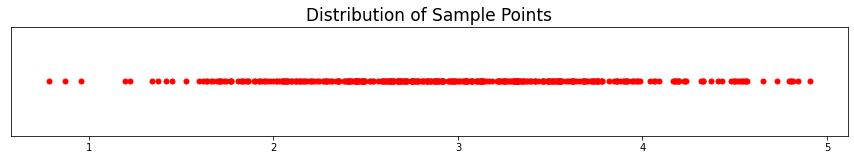

In [51]:
np.random.seed(0)
#Set Mean and Standard Deviation of the red points
red_mean = 3
red_std = 0.8


# Number of the points to generate from the distribution
numberOfRedPoints = 400


# Generate red points using the mean and std
red = np.random.normal(red_mean, red_std, numberOfRedPoints)


print("Mean: ", red_mean)
print("STD: ", red_std)


# Plot the red points
plt.rcParams['figure.figsize'] = (15, 2)
plt.plot(red, np.zeros_like(red), '.', color='r', markersize=10)
plt.title('Distribution of Sample Points', fontsize=17)
plt.yticks([]); # Doesn't show the y coordinates
plt.show()

In [52]:
# Compute the likelihood of the red and blue distributions by computing respective PDF's
red_likelihood = stats.norm(red_mean, red_std).pdf(red)